<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports</a></span></li></ul></li><li><span><a href="#Figure-1:-Causal-graphs-where--$P(Y|do(x))$-is-not-identifiable" data-toc-modified-id="Figure-1:-Causal-graphs-where--$P(Y|do(x))$-is-not-identifiable-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 1: Causal graphs where  $P(Y|do(x))$ is not identifiable</a></span><ul class="toc-item"><li><span><a href="#Figure-1a" data-toc-modified-id="Figure-1a-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Figure 1a</a></span></li><li><span><a href="#Figure-1b" data-toc-modified-id="Figure-1b-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Figure 1b</a></span></li><li><span><a href="#Figure-1c" data-toc-modified-id="Figure-1c-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Figure 1c</a></span></li><li><span><a href="#Figure-1d" data-toc-modified-id="Figure-1d-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Figure 1d</a></span></li><li><span><a href="#Figure-1e" data-toc-modified-id="Figure-1e-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Figure 1e</a></span></li><li><span><a href="#Figure-1f" data-toc-modified-id="Figure-1f-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Figure 1f</a></span></li><li><span><a href="#Figure-1g" data-toc-modified-id="Figure-1g-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Figure 1g</a></span></li><li><span><a href="#Figure-1h" data-toc-modified-id="Figure-1h-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Figure 1h</a></span></li></ul></li><li><span><a href="#Figure-2:-Causal-graphs-admitting-identifiable-effect-$P(y|do(x))$" data-toc-modified-id="Figure-2:-Causal-graphs-admitting-identifiable-effect-$P(y|do(x))$-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 2: Causal graphs admitting identifiable effect $P(y|do(x))$</a></span><ul class="toc-item"><li><span><a href="#Figure-2a" data-toc-modified-id="Figure-2a-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Figure 2a</a></span></li><li><span><a href="#Figure-2b" data-toc-modified-id="Figure-2b-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Figure 2b</a></span></li><li><span><a href="#Figure-2c" data-toc-modified-id="Figure-2c-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Figure 2c</a></span></li><li><span><a href="#Figure-2d" data-toc-modified-id="Figure-2d-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Figure 2d</a></span></li><li><span><a href="#Figure-2e" data-toc-modified-id="Figure-2e-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Figure 2e</a></span></li><li><span><a href="#Figure-2f" data-toc-modified-id="Figure-2f-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Figure 2f</a></span></li><li><span><a href="#Figure-2g" data-toc-modified-id="Figure-2g-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Figure 2g</a></span></li></ul></li><li><span><a href="#Figure-3" data-toc-modified-id="Figure-3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 3</a></span><ul class="toc-item"><li><span><a href="#Figure-3a:-A-graph-hedge-less-for-$P(y|do(x))$" data-toc-modified-id="Figure-3a:-A-graph-hedge-less-for-$P(y|do(x))$-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Figure 3a: A graph hedge-less for $P(y|do(x))$</a></span><ul class="toc-item"><li><span><a href="#Obtained-from-(Shpitser-&amp;-Pearl-2006)" data-toc-modified-id="Obtained-from-(Shpitser-&amp;-Pearl-2006)-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Obtained from (Shpitser &amp; Pearl 2006)</a></span></li><li><span><a href="#Obtained-from-Whittemore" data-toc-modified-id="Obtained-from-Whittemore-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Obtained from Whittemore</a></span></li></ul></li><li><span><a href="#Figure-3b:-A-graph-containing-a-hedge-for-$P(y|do(x))$" data-toc-modified-id="Figure-3b:-A-graph-containing-a-hedge-for-$P(y|do(x))$-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Figure 3b: A graph containing a hedge for $P(y|do(x))$</a></span></li></ul></li><li><span><a href="#Figure-4:-A-complete-identification-algorithm." data-toc-modified-id="Figure-4:-A-complete-identification-algorithm.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 4: A complete identification algorithm.</a></span></li></ul></div>

## Imports

$$P(y|do(x)) = \sum_zP(y|x,z)P(z)$$

In [4]:
%matplotlib inline
from identify import draw_graph, ID, joint_probability_distribution,find_superset, factorize_c_components, Fail
from pgmpy.models import BayesianModel
import identify
from pgmpy.base import DAG
import sys
from pgmpy.factors.continuous import ContinuousFactor
from pgmpy.factors.discrete import TabularCPD, JointProbabilityDistribution
import pandas as pd
import numpy as np
from sympy import Function, Symbol, Eq, simplify, init_printing
from sympy.concrete.summations import Sum
from sympy.core.core import all_classes as sympy_classes
from sympy.concrete.products import Product
from sympy.functions import Abs
from pgmpy.models import BayesianModel
init_printing()

# Figure 1: Causal graphs where  $P(Y|do(x))$ is not identifiable

## Figure 1a

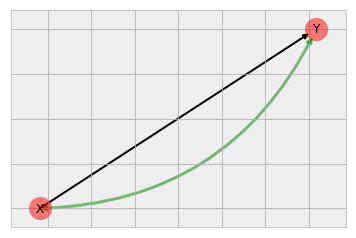

In [2]:
figure_1a = dict(G=DAG([('X','Y')]),
                 U=DAG([('X','Y')]))
figure_1a['U'].add_nodes_from(figure_1a['G'].nodes)

draw_graph(**figure_1a)
            

U = figure_1a['U']

G = figure_1a['G']
x, y = frozenset({'X'}), frozenset({'Y'})


P = joint_probability_distribution( G.nodes )


In [3]:
try:
    ID(y, x, P, G, U)
except identify.Fail as f:
    print(f)

Identification Failure: C-components of U [{'Y', 'X'}] and C-components of (U-x) [{'Y'}] form a hedge


## Figure 1b

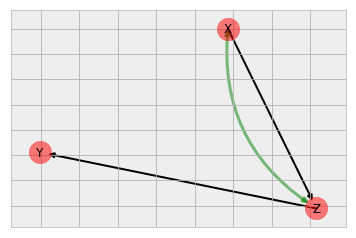

"G - X=frozenset({'X'}):"

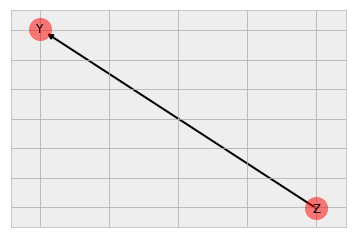

Identification Failure: C-components of U [{'X', 'Z'}] and C-components of (U-x) [{'Z'}] form a hedge


In [4]:
figure_1b = dict(G=DAG([('X','Z'),
                        ('Z','Y')]),
                 U =DAG([('X','Z')]))

draw_graph(**figure_1b)

U = figure_1b['U']
G = figure_1b['G']

U.add_nodes_from( G.nodes )
x, y = frozenset({'X'}), frozenset({'Y'})

P = joint_probability_distribution( G.nodes )

try:
    ID(y, x, P, G, U)
except identify.Fail as f:
    print(f)

## Figure 1c

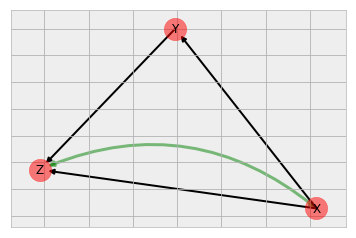

In [5]:
figure_1c = dict(G=DAG([('X','Z'),
                        ('X','Y'),
                        ('Y','Z')]),
                 U=DAG([('X', 'Z')]))
figure_1c['U'].add_nodes_from(figure_1c['G'].nodes)

draw_graph(**figure_1c)

In [6]:
U = figure_1c['U']
G = figure_1c['G']
x, y = frozenset({'X'}), frozenset({'Y'})

P = joint_probability_distribution( G.nodes )

try:
    display(ID(y, x, P, G, U))
except identify.Fail as f:
    print(f)

    │Z│   │Z│               
    ___   ___               
    ╲     ╲                 
     ╲     ╲   P(X, Z, Y)   
     ╱     ╱                
    ╱     ╱                 
    ‾‾‾   ‾‾‾               
   z = 1 z = 1              
────────────────────────────
 │Y│   │Z│   │Z│            
 ___   ___   ___            
 ╲     ╲     ╲              
  ╲     ╲     ╲   P(X, Z, Y)
  ╱     ╱     ╱             
 ╱     ╱     ╱              
 ‾‾‾   ‾‾‾   ‾‾‾            
y = 1 z = 1 z = 1           

## Figure 1d

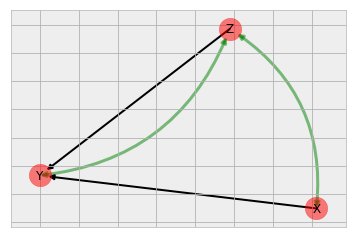

In [7]:
figure_1d = dict(G=DAG([('X','Y'),
                        ('Z','Y')]),
                 U=DAG([('X', 'Z'),
                       ('Y', 'Z')]))
figure_1d['U'].add_nodes_from(figure_1d['G'].nodes)

draw_graph(**figure_1d)

In [8]:
U = figure_1d['U']
G = figure_1d['G']
x, y = frozenset({'X'}), frozenset({'Y'})

P = joint_probability_distribution( G.nodes )
try:
    display(ID(y, x, P, G, U))
except identify.Fail as f:
    print(f)

Identification Failure: C-components of U [{'Y', 'X', 'Z'}] and C-components of (U-x) [{'Y', 'Z'}] form a hedge


## Figure 1e

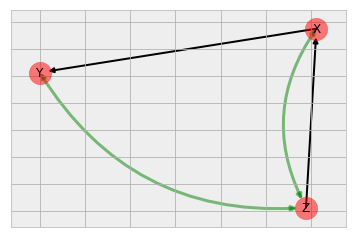

In [9]:
figure_1e = dict(G=DAG([('Z','X'),
                        ('X','Y')]),
                 U=DAG([('X', 'Z'),
                       ('Y', 'Z')]))
figure_1e['U'].add_nodes_from(figure_1e['G'].nodes)

draw_graph(**figure_1e)

In [10]:
U = figure_1e['U']
G = figure_1e['G']
x, y = frozenset({'X'}), frozenset({'Y'})

P = joint_probability_distribution( G.nodes )

try:
    ID(y, x, P, G, U)
except identify.Fail as f:
    print(f)

Identification Failure: C-components of U [{'Y', 'X', 'Z'}] and C-components of (U-x) [{'Y'}] form a hedge


## Figure 1f

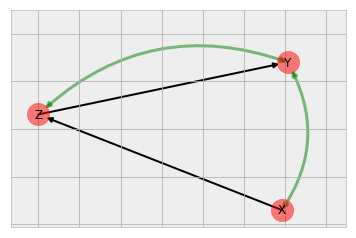

In [11]:
figure_1f = dict(G=DAG([('X','Z'),
                        ('Z','Y')]),
                 U=DAG([('X', 'Y'),
                       ('Y', 'Z')]))
figure_1f['U'].add_nodes_from(figure_1f['G'].nodes)

draw_graph(**figure_1f)

In [12]:
U = figure_1f['U']
G = figure_1f['G']
x, y = frozenset({'X'}), frozenset({'Y'})

P = joint_probability_distribution( G.nodes )

try:
    ID(y, x, P, G, U)
except identify.Fail as f:
    print(f)

Identification Failure: C-components of U [{'Y', 'X', 'Z'}] and C-components of (U-x) [{'Y', 'Z'}] form a hedge


## Figure 1g

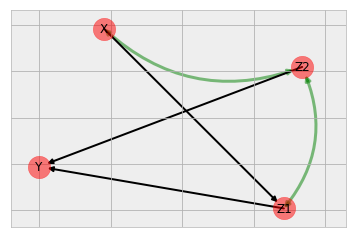

In [13]:
figure_1g = dict(G=DAG([('X','Z1'),
                        ('Z2','Y'),
                        ('Z1', 'Y')]),
                 U=DAG([('X', 'Z2'),
                       ('Z1', 'Z2')]))
figure_1g['U'].add_nodes_from(figure_1g['G'].nodes)

draw_graph(**figure_1g)

"G - X=frozenset({'X'}):"

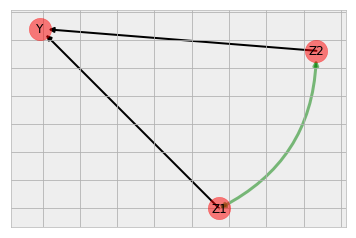

Identification Failure: C-components of U [{'Z1', 'X', 'Z2'}] and C-components of (U-x) [{'Z1', 'Z2'}] form a hedge


In [14]:
U = figure_1g['U']
G = figure_1g['G']
x, y = frozenset({'X'}), frozenset({'Y'})

P = joint_probability_distribution( G.nodes )

try:
    ID(y, x, P, G, U)
except identify.Fail as f:
    print(f)

## Figure 1h

In [ ]:
figure_1h = dict(G=DAG([('Z','X'),
                        ('X','W'),
                        ('W', 'Y')]),
                 U=DAG([('X', 'Z'),
                       ('X', 'Y'),
                       ('Z', 'W'),
                       ('Z', 'Y')]))
figure_1h['U'].add_nodes_from(figure_1h['G'].nodes)

draw_graph(**figure_1h)

In [ ]:
U = figure_1h['U']
G = figure_1h['G']
x, y = frozenset({'X'}), frozenset({'Y'})

P = joint_probability_distribution( G.nodes )

try:
    ID(y, x, P, G, U)
except identify.Fail as f:
    print(f)

# Figure 2: Causal graphs admitting identifiable effect $P(y|do(x))$

## Figure 2a

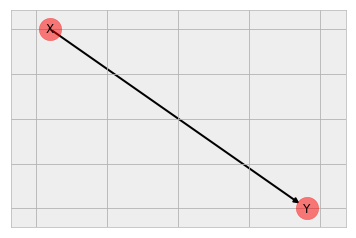

In [5]:
figure_2a = dict(G=DAG([('X','Y')]),
                 U=DAG([]))
figure_2a['U'].add_nodes_from(figure_2a['G'].nodes)

draw_graph(**figure_2a)

In [6]:
U = figure_2a['U']
G = figure_2a['G']
x, y = frozenset({'X'}), frozenset({'Y'})
P = joint_probability_distribution( G.nodes )

try:
    display( ID(y, x, P, G, U) )
except identify.Fail as f:
    print(f)

## Figure 2b

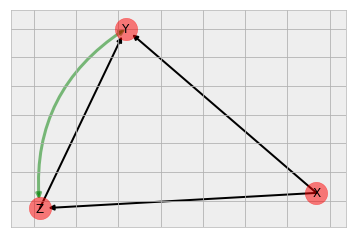

  │Z│                         
_______                       
╲                             
 ╲            P(X, Y, Z)      
  ╲     ──────────────────────
   ╲     │Z│   │Y│            
    ╲    ___   ___            
     ╲   ╲     ╲              
     ╱    ╲     ╲   P(X, Y, Z)
    ╱     ╱     ╱             
   ╱     ╱     ╱              
  ╱      ‾‾‾   ‾‾‾            
 ╱      z = 1 y = 1           
╱                             
‾‾‾‾‾‾‾                       
 z = 1                        

In [13]:
figure_2b = dict(G=DAG([('X','Y'),
                       ('Z','Y'),
                       ('X','Z')]),
                 U=DAG([('Y','Z')]))
figure_2b['U'].add_nodes_from(figure_2b['G'].nodes)

U = figure_2b['U']
G = figure_2b['G']
x, y = frozenset({'X'}), frozenset({'Y'})
P = joint_probability_distribution( G.nodes )

draw_graph(**figure_2b)
try:
    display( ID(y, x, P, G, U) )
except identify.Fail as f:
    print(f)


## Figure 2c

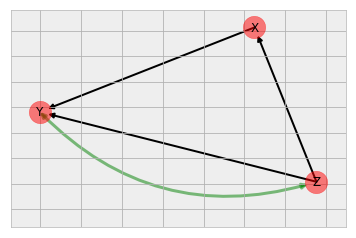

    │Z│                                                    
___________                                                
╲                                                          
 ╲                             │Y│   │X│                   
  ╲                            ___   ___                   
   ╲                           ╲     ╲                     
    ╲                           ╲     ╲   P(Z, X, Y)       
     ╲             P(Z, X, Y)⋅  ╱     ╱                    
      ╲                        ╱     ╱                     
       ╲                       ‾‾‾   ‾‾‾                   
        ╲                     y = 1 x = 1                  
         ╲  ───────────────────────────────────────────────
         ╱  ⎛ │Y│            ⎞  │Z│   │Y│   │X│            
        ╱   ⎜ ___            ⎟  ___   ___   ___            
       ╱    ⎜ ╲              ⎟  ╲     ╲     ╲              
      ╱     ⎜  ╲   P(Z, X, Y)⎟   ╲     ╲     ╲   P(Z, X, Y)
     ╱      ⎜  ╱             ⎟⋅  ╱     ╱

In [14]:
figure_2c = dict(G=DAG([('Z','X'),
                       ('X','Y'),
                       ('Z','Y')]),
                 U=DAG([('Y','Z')]))
figure_2c['U'].add_nodes_from(figure_2c['G'].nodes)

U = figure_2c['U']
G = figure_2c['G']
x, y = frozenset({'X'}), frozenset({'Y'})
P = joint_probability_distribution( G.nodes )

draw_graph(**figure_2c)
try:
    display( ID(y, x, P, G, U) )
except identify.Fail as f:
    print(f)

## Figure 2d

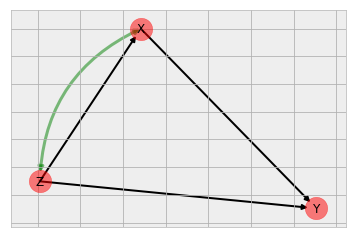

"G - X=frozenset({'X'}):"

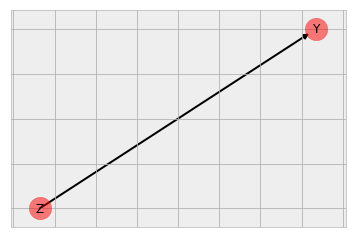

    │Z│                                      
___________                                  
╲                                            
 ╲                      │Y│   │X│            
  ╲                     ___   ___            
   ╲                    ╲     ╲              
    ╲                    ╲     ╲   P(Z, X, Y)
     ╲      P(Z, X, Y)⋅  ╱     ╱             
      ╲                 ╱     ╱              
       ╲                ‾‾‾   ‾‾‾            
        ╲              y = 1 x = 1           
         ╲  ─────────────────────────────────
         ╱            │Y│                    
        ╱             ___                    
       ╱              ╲                      
      ╱                ╲   P(Z, X, Y)        
     ╱                 ╱                     
    ╱                 ╱                      
   ╱                  ‾‾‾                    
  ╱                  y = 1                   
 ╱                                           
╱                                 

In [15]:
figure_2d = dict(G=DAG([('Z','X'),
                       ('X','Y'),
                       ('Z','Y')]),
                 U=DAG([('X','Z')]))
figure_2d['U'].add_nodes_from(figure_2d['G'].nodes)

U = figure_2d['U']
G = figure_2d['G']
x, y = frozenset({'X'}), frozenset({'Y'})
P = joint_probability_distribution( G.nodes )

draw_graph(**figure_2d)
try:
    display( ID(y, x, P, G, U) )
except identify.Fail as f:
    print(f)


## Figure 2e

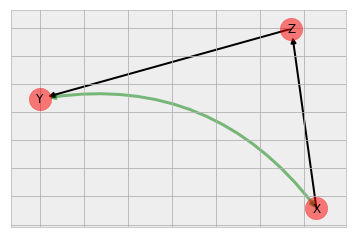

"G - X=frozenset({'X'}):"

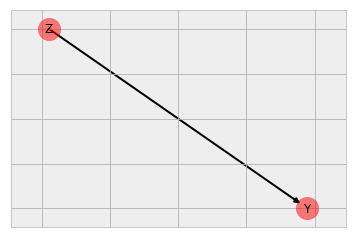

        │Z│                                                                   
___________________                                                           
╲                                                                             
 ╲                  ⎛    │X│                                                  
  ╲                 ⎜___________                                              
   ╲                ⎜╲                                                        
    ╲               ⎜ ╲                             │Y│   │Z│                 
     ╲              ⎜  ╲                            ___   ___                 
      ╲             ⎜   ╲                           ╲     ╲                   
       ╲            ⎜    ╲                           ╲     ╲   P(X, Z, Y)     
        ╲           ⎜     ╲             P(X, Z, Y)⋅  ╱     ╱                  
         ╲          ⎜      ╲                        ╱     ╱                   
          ╲         ⎜       ╲                       

In [16]:
figure_2e = dict(G=DAG([('X','Z'),
                       ('Z','Y')]),
                 U=DAG([('X','Y')]))
figure_2e['U'].add_nodes_from(figure_2e['G'].nodes)

U = figure_2e['U']
G = figure_2e['G']
x, y = frozenset({'X'}), frozenset({'Y'})
P = joint_probability_distribution( G.nodes )

draw_graph(**figure_2e)
try:
    display( ID(y, x, P, G, U) )
except identify.Fail as f:
    print(f)


## Figure 2f

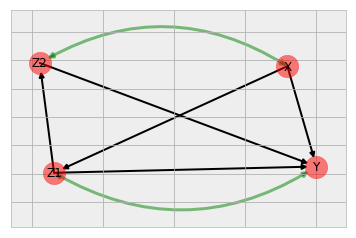

"G - X=frozenset({'X'}):"

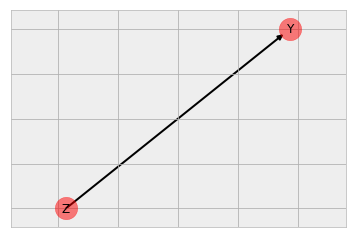

        │Z│                                                                   
___________________                                                           
╲                                                                             
 ╲                  ⎛    │X│                                                  
  ╲                 ⎜___________                                              
   ╲                ⎜╲                                                        
    ╲               ⎜ ╲                             │Y│   │Z│                 
     ╲              ⎜  ╲                            ___   ___                 
      ╲             ⎜   ╲                           ╲     ╲                   
       ╲            ⎜    ╲                           ╲     ╲   P(X, Z, Y)     
        ╲           ⎜     ╲             P(X, Z, Y)⋅  ╱     ╱                  
         ╲          ⎜      ╲                        ╱     ╱                   
          ╲         ⎜       ╲                       

In [17]:
figure_2f = dict(G=DAG([('X','Z1'),
                       ('Z1','Y'),
                       ('X','Y'),
                       ('Z1','Z2'),
                       ('Z2','Y')]),
                 U=DAG([('Z1','Y'),
                       ('X','Z2')]))

U = figure_2e['U']
G = figure_2e['G']
U.add_nodes_from(G.nodes)

x, y = frozenset({'X'}), frozenset({'Y'})
P = joint_probability_distribution( G.nodes )

draw_graph(**figure_2f)
try:
    display( ID(y, x, P, G, U) )
except identify.Fail as f:
    print(f)


## Figure 2g

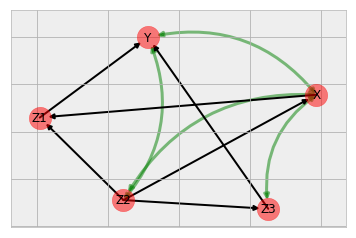

"G - X=frozenset({'X'}):"

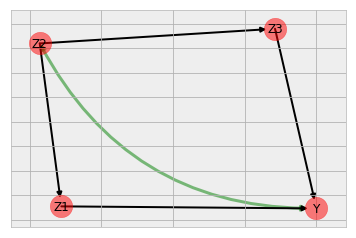

Sum(Sum(P(X, Z1, Y, Z2, Z3)*Sum(P(X, Z1, Y, Z2, Z3), (y, 1, Abs(Y)), (z1, 1, Abs(Z1)))*Sum(P(X, Z1, Y, Z2, Z3), (y, 1, Abs(Y)), (x, 1, Abs(X)), (z1, 1, Abs(Z1)))*Sum(P(X, Z1, Y, Z2, Z3), (y, 1, Abs(Y)), (x, 1, Abs(X)), (z3, 1, Abs(Z3)), (z1, 1, Abs(Z1)))/(Sum(P(X, Z1, Y, Z2, Z3), (y, 1, Abs(Y)))*Sum(P(X, Z1, Y, Z2, Z3), (y, 1, Abs(Y)), (z1, 1, Abs(Z1)), (x, 1, Abs(X)))*Sum(P(X, Z1, Y, Z2, Z3), (y, 1, Abs(Y)), (x, 1, Abs(X)), (z1, 1, Abs(Z1)), (z3, 1, Abs(Z3)))*Sum(P(X, Z1, Y, Z2, Z3), (y, 1, Abs(Y)), (x, 1, Abs(X)), (z3, 1, Abs(Z3)), (z1, 1, Abs(Z1)), (z2, 1, Abs(Z2)))), (x, 1, Abs(X)), (x, 1, Abs(X)), (z1, 1, Abs(Z1)))*Sum(P(X, Z1, Y, Z2, Z3), (z3, 1, Abs(Z3)), (y, 1, Abs(Y)), (z3, 1, Abs(Z3)), (y, 1, Abs(Y)))*Sum(P(X, Z1, Y, Z2, Z3)*Sum(P(X, Z1, Y, Z2, Z3), (y, 1, Abs(Y)), (z1, 1, Abs(Z1)))*Sum(P(X, Z1, Y, Z2, Z3), (y, 1, Abs(Y)), (x, 1, Abs(X)), (z1, 1, Abs(Z1)))*Sum(P(X, Z1, Y, Z2, Z3), (y, 1, Abs(Y)), (x, 1, Abs(X)), (z3, 1, Abs(Z3)), (z1, 1, Abs(Z1)))/(Sum(P(X, Z1, Y, Z2, Z3), (y

In [18]:
figure_2g = dict(G=DAG([('X','Z1'),
                       ('Z1','Y'),
                       ('Z2','X'),
                        ('Z2','Z1'),
                        ('Z2','Z3'),
                        ('Z3','Y')]),
                 U=DAG([('X','Y'),
                        ('X','Z3'),
                        ('X','Z2'),
                        ('Z2','Y')]))

U = figure_2g['U']
G = figure_2g['G']
U.add_nodes_from(G.nodes)

x, y = frozenset({'X'}), frozenset({'Y'})
P = joint_probability_distribution( G.nodes )

draw_graph(**figure_2g)
try:
    print( ID(y, x, P, G, U) )
except identify.Fail as f:
    print(f)


$$\sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\z_{2} \leq Z_{2} \leq \left|{Z_{2}}\right|}} \frac{\left(\sum_{\substack{y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\y \leq Y \leq \left|{Y}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \left(\sum_{\substack{x \leq X \leq \left|{X}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\z_{2} \leq Z_{2} \leq \left|{Z_{2}}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\x \leq X \leq \left|{X}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\x \leq X \leq \left|{X}\right|\\y \leq Y \leq \left|{Y}\right|}} \frac{P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )} \left(\sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\x \leq X \leq \left|{X}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}}{\left(\sum_{Y=y}^{\left|{Y}\right|} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \left(\sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\x \leq X \leq \left|{X}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\x \leq X \leq \left|{X}\right|\\z_{2} \leq Z_{2} \leq \left|{Z_{2}}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}}\right) \left(\sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\x \leq X \leq \left|{X}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\x \leq X \leq \left|{X}\right|\\x \leq X \leq \left|{X}\right|\\y \leq Y \leq \left|{Y}\right|\\y \leq Y \leq \left|{Y}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \sum_{\substack{x \leq X \leq \left|{X}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\z_{2} \leq Z_{2} \leq \left|{Z_{2}}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\x \leq X \leq \left|{X}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\x \leq X \leq \left|{X}\right|\\y \leq Y \leq \left|{Y}\right|\\y \leq Y \leq \left|{Y}\right|}} \frac{P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )} \left(\sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\x \leq X \leq \left|{X}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}}{\left(\sum_{Y=y}^{\left|{Y}\right|} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \left(\sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\x \leq X \leq \left|{X}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\x \leq X \leq \left|{X}\right|\\z_{2} \leq Z_{2} \leq \left|{Z_{2}}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}}}{\left(\sum_{\substack{y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \left(\sum_{\substack{x \leq X \leq \left|{X}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\z_{2} \leq Z_{2} \leq \left|{Z_{2}}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\x \leq X \leq \left|{X}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\x \leq X \leq \left|{X}\right|\\y \leq Y \leq \left|{Y}\right|\\y \leq Y \leq \left|{Y}\right|}} \frac{P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )} \left(\sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\x \leq X \leq \left|{X}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}}{\left(\sum_{Y=y}^{\left|{Y}\right|} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \left(\sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\x \leq X \leq \left|{X}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\x \leq X \leq \left|{X}\right|\\z_{2} \leq Z_{2} \leq \left|{Z_{2}}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}}\right) \left(\sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\x \leq X \leq \left|{X}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\x \leq X \leq \left|{X}\right|\\x \leq X \leq \left|{X}\right|\\y \leq Y \leq \left|{Y}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \sum_{\substack{x \leq X \leq \left|{X}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\z_{2} \leq Z_{2} \leq \left|{Z_{2}}\right|\\z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\x \leq X \leq \left|{X}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\x \leq X \leq \left|{X}\right|\\y \leq Y \leq \left|{Y}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{2} \leq Z_{2} \leq \left|{Z_{2}}\right|}} \frac{P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )} \left(\sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\x \leq X \leq \left|{X}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}}{\left(\sum_{Y=y}^{\left|{Y}\right|} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \left(\sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\x \leq X \leq \left|{X}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}\right) \sum_{\substack{z_{1} \leq Z_{1} \leq \left|{Z_{1}}\right|\\y \leq Y \leq \left|{Y}\right|\\z_{3} \leq Z_{3} \leq \left|{Z_{3}}\right|\\x \leq X \leq \left|{X}\right|\\z_{2} \leq Z_{2} \leq \left|{Z_{2}}\right|}} P{\left (X,Z_{1},Y,Z_{2},Z_{3} \right )}}}$$
 


# Figure 3

We give an example of the operation of the algorithm by identifying $P_x(y_1 , y_2 )$ from $P(\mathbf v)$ in the graph shown in in Fig. 3 (a). Since $G = G_{An(\{Y_1, Y_2\})}$,  $C(G - \{X\}) = \{G\}$, and $W = \{W_1\}$ , we invoke line 3 and attempt to identify $P_{x,w} (y_1, y_2 )$. Now $C(G - \{X, W \}) = \{Y_1, W_2 \rightarrow Y_2\}$ , so we invoke line 4. Thus the original problem reduces to identifying $\sum_{w_2}P_{x,w_1, w_2, y_2} (y_1 )P_{w,x,y_1} (w_2, y_2 )$. Solving for the second expression, we trigger line 2, noting that we can ignore nodes which are not ancestors of $W_2$ and $Y_2$ , which means $P_{w,x,y_1}(w_2, y_2 ) = P(w_2, y2 )$. Solving for the first expression, we first trigger line 2 also, obtaining $P_{x,w_1,w_2,y_2} (y_1 ) = P_{x, w} (y_1 )$. The corresponding $G$ is shown in Fig. 5 (a). Next, we trigger line 7, reducing the problem to computing $P_w(y_1 )$ from $P(Y_1 |X,  W_1 )P(W_1 )$. The corresponding $G$ is shown in Fig. 5 (b). Finally, we trigger line 2, obtaining $P_w(y_1 ) = \sum_{w_1}P(y_1 | x , w_1 )P(w_1 )$. Putting everything together, we obtain: 
$$P_x (y_1 , y_2 ) = \sum_{w_2} P(y_1, w_2 ) \sum_{w_1} P(y_1 | x , w_1 )P(w_1 )$$. 

## Figure 3a: A graph hedge-less for $P(y|do(x))$

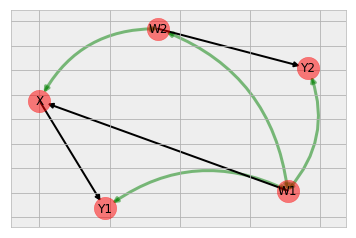

<IPython.core.display.Latex object>

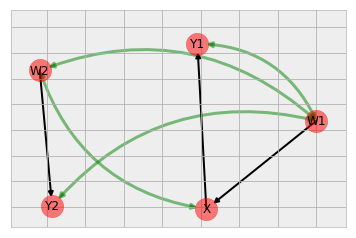

Line 3


<IPython.core.display.Latex object>

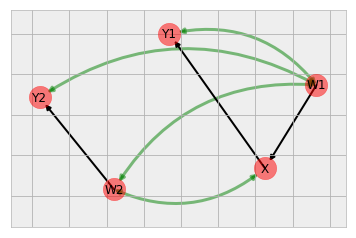

-C_x: [{'Y1'}, {'Y2'}, {'W2'}]
-Line 4


"-G - X=frozenset({'X', 'W1'}):"

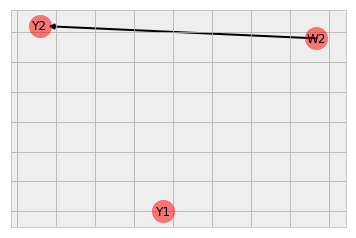

<IPython.core.display.Latex object>

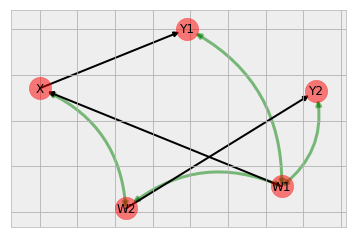

--Line 2
--Removing non-ancestors of Y={'Y1'}:  {'Y2', 'W2'}


<IPython.core.display.Latex object>

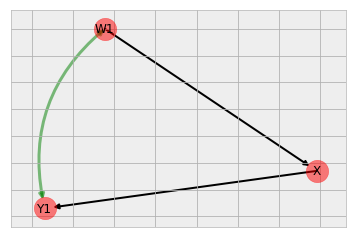

---C_x: [{'Y1'}]
---C-component of U_x: [{'Y1'}]
---C-component of U: [{'W1', 'Y1'}, {'X'}]
---Is C(U)={'W1', 'Y1'} equal to U={'X', 'W1', 'Y1'}: False
---Line 7
---Found superset: {'W1', 'Y1'}


<IPython.core.display.Latex object>

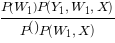

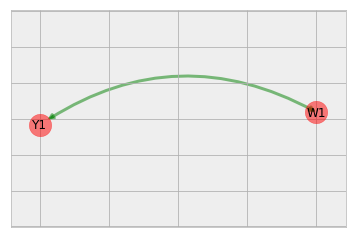

----Line 2
----Removing non-ancestors of Y={'Y1'}:  {'W1'}


<IPython.core.display.Latex object>

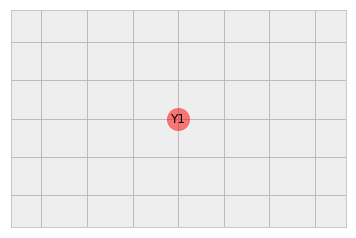

-----Line 1


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

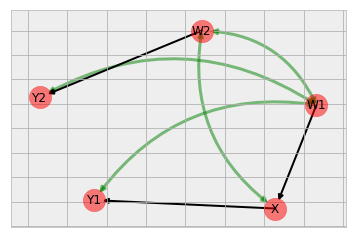

--Line 2
--Removing non-ancestors of Y={'Y2'}:  {'X', 'W1', 'Y1'}


<IPython.core.display.Latex object>

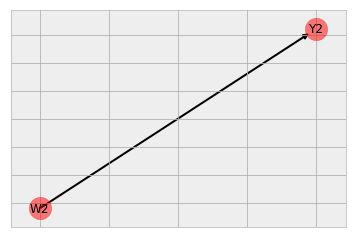

---C_x: [{'Y2'}]
---C-component of U_x: [{'Y2'}]
---C-component of U: [{'Y2'}, {'W2'}]
---Is C(U)={'Y2'} equal to U={'Y2', 'W2'}: False
---Line 6


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

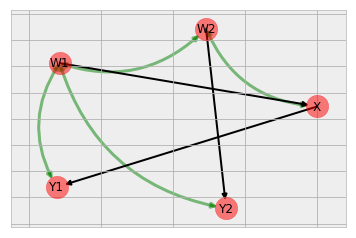

--Line 2
--Removing non-ancestors of Y={'W2'}:  {'X', 'W1', 'Y2', 'Y1'}


<IPython.core.display.Latex object>

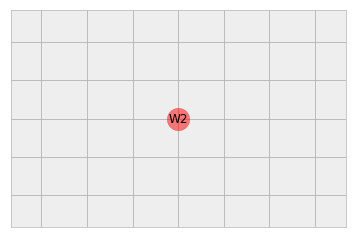

---Line 1


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

'-Returning back to Line 4'

In [2]:
figure_3a = dict(G=DAG([('W1','X'),
                        ('X','Y1'),
                        ('W2','Y2')]),
                 U=DAG([('W1','Y1'),
                        ('W1','W2'),
                        ('W2','X'),
                        ('W1','Y2')]))

U = figure_3a['U']
G = figure_3a['G']
U.add_nodes_from( G.nodes )
x, y = frozenset({'X'}), frozenset({'Y1', 'Y2'})
P = joint_probability_distribution( G.nodes )

draw_graph(**figure_3a)
try:
    display(ID(y, x, P, G, U, debug=True))
except identify.Fail as f:
    print(f)
    


In [13]:
P.free_symbols - set([Symbol(str(Symbol('X')).upper())])


### Obtained from (Shpitser & Pearl 2006)
$$P(y_1,y_2|do(x))= \sum_{w_2}P(y_2|w_2)P(w_2)\sum_{w_1}P(y_1|x, w_1)P(w_1)$$



### Obtained from Whittemore


$$\left[ \sum_{\text{W2}} \left[ \sum_{\text{W1}} \frac{\left[ \sum_{X, \text{Y1}} \left[ \sum_{\text{W2}, \text{Y2}} P(\text{W1}, \text{W2}, X, \text{Y1}, \text{Y2}) \right] \right]}{\left[ \sum_{\text{W1}} \left[ \sum_{X, \text{Y1}} \left[ \sum_{\text{W2}, \text{Y2}} P(\text{W1}, \text{W2}, X, \text{Y1}, \text{Y2}) \right] \right] \right]} \frac{\left[ \sum_{\text{W2}, \text{Y2}} P(\text{W1}, \text{W2}, X, \text{Y1}, \text{Y2}) \right]}{\left[ \sum_{\text{Y1}} \left[ \sum_{\text{W2}, \text{Y2}} P(\text{W1}, \text{W2}, X, \text{Y1}, \text{Y2}) \right] \right]} \right] \left[ \sum_{\text{W1}, X, \text{Y1}, \text{Y2}} P(\text{W1}, \text{W2}, X, \text{Y1}, \text{Y2}) \right] \frac{\left[ \sum_{\text{W1}, X, \text{Y1}} P(\text{W1}, \text{W2}, X, \text{Y1}, \text{Y2}) \right]}{\left[ \sum_{\text{Y2}} \left[ \sum_{\text{W1}, X, \text{Y1}} P(\text{W1}, \text{W2}, X, \text{Y1}, \text{Y2}) \right] \right]} \right] \\ $$

## Figure 3b: A graph containing a hedge for $P(y|do(x))$

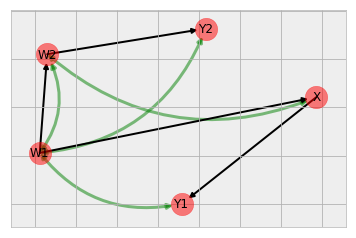

<IPython.core.display.Latex object>

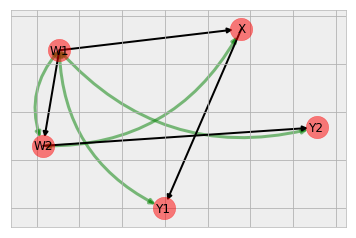

C_x: [{'W1', 'W2', 'Y2', 'Y1'}]
C-component of U_x: [{'W1', 'W2', 'Y2', 'Y1'}]
C-component of U: [{'Y2', 'W1', 'W2', 'X', 'Y1'}]
Is C(U)={'Y2', 'W1', 'W2', 'X', 'Y1'} equal to U={'Y2', 'W1', 'W2', 'X', 'Y1'}: True
Line 5
Identification Failure: C-components of U [{'Y2', 'W1', 'W2', 'X', 'Y1'}] and C-components of (U-x) [{'W1', 'W2', 'Y2', 'Y1'}] form a hedge


In [16]:
figure_3b = dict(G=DAG([('W1','X'),
                   ('X','Y1'),
                   ('W2','Y2'),
                   ('W1','W2')]),
                 U=DAG([('W1','Y1'),
                        ('W1','W2'),
                        ('W2','X'),
                        ('W1','Y2')]))

U = figure_3b['U']
G = figure_3b['G']
U.add_nodes_from( G.nodes )
x, y = frozenset({'X'}), frozenset({'Y1', 'Y2'})
P = joint_probability_distribution( G.nodes )

draw_graph(**figure_3b)
try:
    display(ID(y, x, P, G, U, debug=True))
except identify.Fail as f:
    print(f)

In [ ]:
import sympy
display(sympy.latex(Symbol('Y1')))

In [ ]:
ID(y, x, P, G, U)

# Figure 4: A complete identification algorithm. 

**FAIL** propagates through recursive calls like an exception, and returns the hedge which witnesses non-identifiability. $V_\pi^{(i-1)}$ is the set of nodes preceding $V_i$ in some topological ordering $\pi$ in $G$.

1. If no action has been taken, the effect on $\mathbf Y$ is just the marginal of the observational distribution $P(\mathbf v)$ on $\mathbf Y$. 
2. If we are interested in the effect on $\mathbf Y$, it is sufficient to restrict our attention on the parts of the model ancestral to $\mathbf Y$.
3. Forces an action on any node where such an action would have no effect on $\mathbf Y$—assuming we already acted on $\mathbf X$. Since actions remove incoming arrows, we can view line 3 as simplifying the causal graph we consider by removing certain arcs from the graph, without affecting the overall answer.
4. The key line of the algorithm, it decomposes the problem into a set of smaller problems using the key property of *c-component factorization* of causal models. If the entire graph is a single C-component already, further problem decomposition is impossible, and we must provide base cases. $\mathbf{ID}$ has three base cases. 
5. Fails because it finds two C-components, the graph $G$ itself, and a subgraph $S$ that does not contain any $\mathbf X$ nodes. But that is exactly one of the properties of C-forests that make up a hedge. In fact, it turns out that it is always possible to recover a hedge from these two c-components.
6. Asserts that if there are no bidirected arcs from X to the other nodes in the current subproblem under consideration, then we can replace acting on X by conditioning, and thus solve the subproblem. 
7. The most complex case where $\mathbf X$ is partitioned into two sets, $\mathbf W$ which contain bidirected arcs into other nodes in the subproblem, and $\mathbf Z$ which do not. In this situation, identifying $P(\mathbf y|do(\mathbf x))$ from $P(v)$ is equivalent to identifying $P(\mathbf y|do(\mathbf w))$ from $P(\mathbf V|do(\mathbf z))$, since $P(\mathbf y|do(\mathbf x)) = P(\mathbf y|do(\mathbf w), do(\mathbf z))$. But the term $P(\mathbf V|do(\mathbf z))$ is identifiable using the previous base case, so we can consider the subproblem of identifying $P(\mathbf y|do(\mathbf w))$.


$\text{function }\mathbf{ID}\left(\mathbf y, \mathbf x, P, G\right) \\ \text{INPUT: } \mathbf{x,y}\text{ value assignments, $P$ a probability distribution, $G$ a causal diagram}. \\  \text{OUTPUT:  Expression for $P_{\mathbf x}(\mathbf y)$ in terms of $P$ or $\mathbf{FAIL}(F, F')$} $



1. $\text{if }{\mathbf x} =\emptyset \text{ return }\sum_{\mathbf v - \mathbf y}P({\mathbf v})$. &nbsp;&nbsp;&nbsp; 
2. $\text{if }\mathbf V - An(\mathbf Y)_G \neq \emptyset \\  \text{ return } \mathbf{ ID}\left(\mathbf y, \mathbf x\cap An(\mathbf Y)_G, \sum_{\mathbf V - An(Y)_G}P, G_{An(\mathbf Y)}\right)$.
3. $\text{let }\mathbf W = (\mathbf V - X) - An(\mathbf Y)_{G_{\bar{\mathbf X}}}. \\ \text{if } \mathbf W \neq \emptyset, \text{ return } \mathbf{ID}\left(\mathbf y, \mathbf x\cup \mathbf w, P, G\right)$.
4. $\text{if }C(G-\mathbf X) = \{S_1,\ldots S_k\} \\ \text{ return }\sum_{\mathbf v - (\mathbf y \cup \mathbf x)}\prod_i\mathbf{ID}\left(s_i, \mathbf v - s_i, P, G\right) \\ \text{if }C(G -\mathbf X) = \{S\}$
5. &nbsp; &nbsp;&nbsp;$\text{       if }C(G) = \{G\},\\  \text{ throw }\mathbf{FAIL}\left(G,G\cap S\right)$.
6. &nbsp; &nbsp;&nbsp;$\text{ if }S\in C(G) \\ \text{ return }\sum_{S - \mathbf y}\prod_{\{i|V_i\in S\}}P\left(v_i|v_\pi^{(i-1)}\right)$
7. &nbsp; &nbsp;&nbsp;$\text{ if }(\exists S')S\subset S'\in C(G) \\ \text{ return }\mathbf{ID}\left(\mathbf y, \mathbf x\cap S', \prod_{\{i|V_i\in S'\}}P(V_i|V_\pi^{(i-1)}\cap S', v_\pi^{(i-1)} - S'), G_{S'}\right)$.



In [2]:
%%writefile identify.py

import networkx as nx
from matplotlib import pylab as plt
import seaborn as sns
import inspect
from collections import OrderedDict
from pgmpy.base import DAG
from pgmpy.extern.six.moves import reduce
import numpy as np
import pandas as pd
from numpy.random import randn
from itertools import product
from IPython.display import Latex
import sys
from matplotlib.patches import FancyArrowPatch, Circle 
from sympy import Function, Symbol, Eq, simplify, init_printing, latex
from sympy.concrete.summations import Sum
from sympy.core.core import all_classes as sympy_classes
from sympy.concrete.products import Product
from sympy.functions import Abs
from IPython.display import display, Latex


class Fail(Exception):
    pass



def draw_graph( G, U ):
    pos = nx.spring_layout(G)
    V = G.nodes
    #nx.draw(G, pos)
    
    nx.draw_networkx_nodes(G, pos,
                       nodelist=V,
                       node_color='r',
                       node_size=500,
                       alpha=0.5)
    nx.draw_networkx_edges(U, pos,
                       edgelist=list(U.edges),
                       linestyle='dashed',
                       edge_color='green',
                       arrows=True,
                       arrowstyle='<|-|>',
                       connectionstyle="arc3,rad=0.3",
                       width=3, alpha=0.5)
    nx.draw_networkx_edges(G, pos,
                          edgelist=list(G.edges),
                          edge_color='black',
                          style='solid',
                          width=2 )
    nx.draw_networkx_labels(G, pos)
    plt.show()

def to_frame(self, tablefmt="fancy_grid", print_state_names=True):
        headers_list = []
        # build column headers

        evidence = self.variables[1:]
        evidence_card = self.cardinality[1:]
        if evidence:
            col_indexes = np.array(list(product(*[range(i) for i in evidence_card])))
            if self.state_names and print_state_names:
                for i in range(len(evidence_card)):
                    column_header = [str(evidence[i])] + ['{var}({state})'.format
                                                     (var=evidence[i],
                                                      state=self.state_names[evidence[i]][d])
                                                     for d in col_indexes.T[i]]
                    headers_list.append(column_header)
            else:
                for i in range(len(evidence_card)):
                    column_header = [str(evidence[i])] + ['{s}_{d}'.format(s=evidence[i], d=d) 
                                                          for d in col_indexes.T[i]]
                    headers_list.append(column_header)

        # Build row headers
        if self.state_names and print_state_names:
            variable_array = [['{var}({state})'.format
                               (var=self.variable, state=self.state_names[self.variable][i])
                               for i in range(self.variable_card)]]
        else:
            variable_array = [['{s}_{d}'.format(s=self.variable, d=i) for i in range(self.variable_card)]]
        # Stack with data
        labeled_rows = np.hstack((np.array(variable_array).T, self.get_values())).tolist()
        # No support for multi-headers in tabulate
        if len(headers_list) > 0:
            column_idx = pd.MultiIndex.from_arrays([header[1:] for header in headers_list],
                                              names= [header[0] for header in headers_list])
            row_idx_name = 'P({}|{})'.format(self.variable, ','.join(column_idx.names))
        else:
            column_idx = [self.variable]
            row_idx_name = 'P({})'.format(self.variable)
        df = pd.DataFrame(self.get_values(), columns=column_idx, index=variable_array)
        df.index.name = row_idx_name
        return df

def adjacent_nodes( pairs, node ):
    "Returns the nodes adjacent to node (via the bidirected edges in pairs)."
    adjacent_nodes = set()
    for pair in pairs:
        if node in pair:
            adjacent_nodes |= set(pair)
    return list(adjacent_nodes - set([node]))
   
def factorize_c_components( U ):
    """Returns the confounded components of G as a list of sets of vertices"""
    def recur(nodes = list(U.nodes), components = list()):
        if len(nodes) == 0:
            return components
        else:
            current_node = nodes[0]
            current_component = connected_component( U.edges ,
                                                     current_node )
            #print('found connected component {} of node {}'.format(current_component, current_node))
            
            return recur( list(set(nodes[1:]) - current_component ),
                          components + [current_component] ) 
    return recur()
def connected_component( pairs, node ):
    def recur( frontier=[node], visited=set() ):
        if len(frontier) == 0:
            return visited
        else:
            current = frontier[0]
            if current in visited:
                return recur( frontier[1:], visited )
            else:
                visited.add( current )
                return recur( frontier[1:] + adjacent_nodes( pairs, current),
                              visited )
    return recur( )


def remove_nodes_from( G , x ):
    G_x = G.copy()
    G_x.remove_nodes_from( x )
    return G_x

def predecessors( pi, v ):
    return list(pi)[:pi.index(v)]

def marginalize( marginals, P ):
    if type(P) is list:
        return pgmpy_marginalize( marginals, P )
    if type(P) in sympy_classes:
        return sympy_marginalize( marginals, P )

def sympy_marginalize( marginals, P ):
    V = P.free_symbols - set([Symbol(m.upper()) for m in marginals])
    return joint_probability_distribution( V )

def old_sympy_marginalize( marginals, P ):
    for marginal in marginals:
        V = Symbol(marginal.upper())
        if V in P.free_symbols:
            v = Symbol(str(V).lower())
            P = Sum(P, (v, 1, Abs(V)) )
        else:
            print('Marginal {} is not a free variable in P: {}'.format(V, P.free_symbols))
    return P
def pgmpy_marginalize( marginals, P ):
    return [Pv.marginalize( (set(Pv.scope()) & marginals) - set([Pv.variable]),
                          inplace=False)
           for Pv in P]

def predecessors( pi, vi ):
    return pi[:pi.index(vi)]
def sympy_given( P, vi, pi ):
    pred    = predecessors( pi, vi )
    unbound = set([str(v) for v in P.free_symbols]) - (set([vi]) | set(pred) )
    numer   = marginalize( unbound, P )
    denom   = marginalize( set([vi]), numer )
    return numer/denom

def given( P, vi, pi ):
    if type( P ) in sympy_classes:
        return sympy_given( P, vi, pi )
    elif type( P ) is str:
        return pgmpy_given( P, vi, pi )
    
        
def sum_product( marginals, P ):
    if type(P) is list:
        return pgmpy_sum_product( marginals, P )
    elif type(P) in sympy_classes:
        return sympy_sum_product( marginals, P )

def sympy_product( P_list ):
    P_product = P_list[0]
    if len(P_list) > 1:
        for P in P_list[1:]:
            P_product *= P
    return P_product

def product( P_list ):
    if all([type(P) is list for P in P_list]):
        return pgmpy_product( P_list )
    elif all([type( P ) in sympy_classes for P in P_list]):
        return sympy_product( P_list )

def pgmpy_product( P_list ):
    P_product = P_list[0]
    if len(P_list) > 1:
        return factor_product( *P )
    elif len(P_list) == 1:
        return P_product
    else:
        raise NameError("P is empty!")
def sympy_sum_product( marginals, P_list ):
    return old_sympy_marginalize( marginals, product( P_list ) )
    

def pgmpy_sum_product(  marginals, P ):
    if len(P) > 1:
        return factor_product( *P ).\
               marginalize( marginals, inplace=False )
    elif len(P) == 1:
        return P[0].marginalize( marginals, inplace=False )
    else:
        raise NameError("P is empty!")
        
def joint_probability_distribution( vertices ):
    P = Function('P')
    return P(*[Symbol(str(V).upper()) for V in vertices])

def cut_incoming( G, x ):
    G_x = G.copy()
    for edge in G.edges:
        if edge[1] in x:
            G_x.remove_edge( *edge )
    return G_x
def draw_bidirected_graph( bigraph ):
    pos = nx.spring_layout(bigraph)
    nx.draw(bigraph, pos)
    nx.draw_networkx_labels(bigraph, pos)
    plt.show()

def find_superset( C_component, s ):
    for s_prime in C_component:
        if len(s - s_prime) == 0:
            return s_prime
    return []

def display_P( P ):
    if type(P) is list:
        return [display(to_frame(cpd)) for cpd in P]
    elif type(P) in sympy_classes:
        return display(P)
def ID( y, x, P, G, U, debug=False, recurse_level = 0 ):
    if debug:
        display(Latex('{}Identify $P({} | {})$'.format('-'*recurse_level,','.join([latex(Symbol(yi)) for yi in sorted(y)]), 
                                        ','.join(['do({})'.format(latex(Symbol(xi)))
                                                  for xi in sorted(x)]))))
        display_P( P) 
        draw_graph( G, U)
    v = set(G.nodes)
    # line 1
    if len(x) == 0:
        if debug:
            print('{}Line 1'.format('-'*recurse_level))
            display(Latex('{}No $do(X)$. Return ${}$'.format('-'*recurse_level,  latex(marginalize( v - y, P)))))
        return marginalize( v - y, P )
    # line 2
    ancestors_y = set(G._get_ancestors_of( list(y) ))
    
    if len(v - ancestors_y) > 0:
        if debug:
            print('{}Line 2'.format('-'*recurse_level))
            print('{}Removing non-ancestors of Y={}:  {}'.format('-'*recurse_level, y,  v - ancestors_y ))
        return ID( y, 
                   x & ancestors_y,
                   marginalize( v - ancestors_y, P ),
                   G.subgraph( ancestors_y ),
                   U.subgraph( ancestors_y ),
                   debug = debug,
                   recurse_level = recurse_level + 1
          )
    
    # line 3
    G_bar_x = cut_incoming( G, x )
    w = (v - x) - G_bar_x._get_ancestors_of( list(y) )
    if len( w ) > 0:
        if debug:
            print('{}Line 3'.format('-'*recurse_level))
        return ID( y, x | w, P, G, U, debug=debug, recurse_level = recurse_level + 1 )
        
    # line 4
    U_x = remove_nodes_from( U, x )
    G_x = remove_nodes_from( G, x )
    
    C_components_of_U_x = factorize_c_components( U_x )
    if debug:
        print('{}C_x: {}'.format('-'*recurse_level,C_components_of_U_x))
    if len(C_components_of_U_x) > 1:
        if debug:
            print('{}Line 4'.format('-'*recurse_level))
            display('{}G - X={}:'.format('-'*recurse_level,x))
        draw_graph( G_x, U_x)
        P_list = []
        for C_component in C_components_of_U_x:
            Ps = ID( C_component, v - C_component, P, G, U, debug=debug, recurse_level=recurse_level + 1 )
            if debug:
                display(Latex('{}\tC-component Identify $P({} | {}) = {}$'.format(
                              '-'*recurse_level,
                              ','.join([latex(Symbol(yi)) 
                                  for yi in sorted(C_component)]), 
                              ','.join(['do({})'.format(latex(Symbol(xi)))
                                     for xi in sorted(v - C_component)]),
                               latex(Ps))))
            
            P_list.append( Ps )
        if debug:
            display('{}Returning back to Line 4'.format('-'*recurse_level))
        return marginalize( v - (x|y), 
                            product(P_list ))

    
    else:
        # line 5
        if debug:
            print('{}C-component of U_x: {}'.format('-'*recurse_level, C_components_of_U_x))
        if len(C_components_of_U_x) == 1:
            S_x = C_components_of_U_x[0]
        else:
            S_x = set()
        C_components_of_U = factorize_c_components( U )
        if debug:
            print('{}C-component of U: {}'.format('-'*recurse_level, C_components_of_U))
            print('{}Is C(U)={} equal to U={}: {}'.format('-'*recurse_level,  C_components_of_U[0], set(U.nodes), C_components_of_U[0] == set(U.nodes)))
        if len(C_components_of_U) == 1 and C_components_of_U[0] == set(U.nodes):
            if debug:
                print('{}Line 5'.format('-'*recurse_level))
            raise Fail( 
                "{}Identification Failure: C-components of U {} and C-components of (U-x) {} form a hedge".format(
                    '-'*recurse_level, C_components_of_U, C_components_of_U & S_x ))

        # line 6
        pi = list(nx.topological_sort( G ))
        if S_x  in C_components_of_U:
            if debug:
                print('{}Line 6'.format('-'*recurse_level))
            return marginalize(S_x - y, 
                               product([given( P, vi, pi )  # P( vi | pi )
                                         for vi in S_x] ))
        # line 7
        S_prime = find_superset( C_components_of_U, S_x )  
        if len(S_prime) > 0:
            if debug:
                print('{}Line 7'.format('-'*recurse_level))
                print('{}Found superset: {}'.format( '-'*recurse_level, S_prime ))
            P_prime = product([given( P, vi, pi )
                               for vi in S_prime])
            return ID( y,
                       x & S_prime,
                       P_prime,
                       G.subgraph( S_prime ), 
                       U.subgraph( S_prime ), 
                       debug = debug,
                       recurse_level = recurse_level + 1
                     )
        else:
            raise Error("{}S' is empty".format('-'*recurse_level))

Overwriting identify.py
